# Coefficients of variation by season (2015-2019)

Plot the variations in lap times of each driver over the course of an entire season

In [21]:
# import libraries

import numpy as np
import pandas as pd
from psycopg2 import connect, extensions, sql
from IPython.display import clear_output
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
from datetime import datetime, time, date
from collections import defaultdict

# load login info for postgres 

with open("postgres_login_info.txt") as f: 
    login_info = f.read()
mpl.rcParams['figure.max_open_warning'] = 50

In [22]:
# Define a function to run a query

def query(text):
    """Run a query on the Formula_1_statistics database using the text input
    Parameters
    ---------
    text: SQL code to run
    
    Returns
    ---------
    df: DataFrame containing the result of the submitted query
    
    """
    with connect(login_info) as conn, conn.cursor() as cur:  
        autocommit = extensions.ISOLATION_LEVEL_AUTOCOMMIT
        conn.set_isolation_level(autocommit)
        
        query = sql.SQL(text)
        cur.execute(query)
        return pd.DataFrame(cur.fetchall(), columns = [desc[0] for desc in cur.description])

In [23]:
# define dictionaries for team colors and abbreviations

colors = defaultdict(lambda: '#FFFFFF', {
                     'Mercedes'      : '#00D2BE', 
                     'Ferrari'       : '#C00000', 
                     'Red Bull'      : '#0600EF', 
                     'Renault'       : '#FFF500', 
                     'Haas F1 Team'  : '#787878', 
                     'Racing Point'  : '#F596C8', 
                     'Force India'   : '#F596C8', 
                     'AlphaTauri'    : '#C8C8C8',
                     'Toro Rosso'    : '#469BFF',
                     'McLaren'       : '#FF8700', 
                     'Alfa Romeo'    : '#960000',
                     'Sauber'        : '#960000',
                     'Williams'      : '#0082FA', 
                     'Lotus F1'      : '#FFB800',
                     'Manor Marussia': '#6E0000'
                    })
team_abbrev = defaultdict(lambda: 'NA', {
                     'Mercedes'      : 'Merc', 
                     'Ferrari'       : 'Fer', 
                     'Red Bull'      : 'RB', 
                     'Renault'       : 'Ren', 
                     'Haas F1 Team'  : 'Has', 
                     'Racing Point'  : 'RP', 
                     'Force India'   : 'FI', 
                     'AlphaTauri'    : 'AT', 
                     'Toro Rosso'    : 'TR', 
                     'McLaren'       : 'McL', 
                     'Alfa Romeo'    : 'AR', 
                     'Sauber'        : 'Sau', 
                     'Williams'      : 'Wil',
                     'Lotus F1'      : 'Lot', 
                     'Manor Marussia': 'MM'
                    })

In [24]:
# return the lap times for 1 driver over 1 race, filtering out pit stops and safety car periods, which are defined as a lap
# time above a certain percentage of the fastest lap of the race (20% by default). This allows drivers to still be 
# peanilized for various spins and shunts

def get_lap_distribution(firstname=None, lastname=None, driverref=None, race_name=None, year=None, cutoff=1.2): 
    """Run a query to find the lap times for a driver over the course of 1 race"""
    
    text = f"""
    -- construct gp info
    WITH gps AS (SELECT EXTRACT(MINUTES FROM lap_times.time)*60 +
                            EXTRACT(SECONDS FROM lap_times.time) AS lap_time, 
                        lap_times.lap, 
                        lap_times.position, 
                        lap_times.driverid, 
                        lap_times.raceid,
                        EXTRACT(YEAR FROM races.date) AS year
                 FROM lap_times 
                 JOIN races ON lap_times.raceid = races.raceid 
                 JOIN circuits ON races.circuitid = circuits.circuitid
                 WHERE ((races.name iLike '%{race_name}%') AND year = {year})
                 ), 
                 
    -- construct pit info
    pits AS (SELECT pit_stops.driverid, 
                    pit_stops.raceid, 
                    pit_stops.stop, 
                    pit_stops.lap AS pit_lap, 
                    pit_stops.time, 
                    pit_stops.duration
             FROM pit_stops
             JOIN races ON pit_stops.raceid = races.raceid
             JOIN drivers ON pit_stops.driverid = drivers.driverid
             WHERE(
                  (races.name iLike '%{race_name}%') 
                   AND year = {year}
                   AND ((drivers.forename iLike '%{firstname}%'
                       AND drivers.surname iLike '%{lastname}%') 
                        OR drivers.driverref iLike '%{driverref}%')
              )
    ),
    
    
    -- find the fastest lap to filter safety car laps
    fastest_lap AS (SELECT MIN(gps.lap_time) AS time FROM gps) 
        
    -- put it all together
    SELECT gps.lap,
           gps.year, 
           gps.lap_time,
           gps.position,
           drivers.code,
           races.name,
           -- whether or not the driver retired
           CASE WHEN ((SELECT MAX(gps.lap)
                       FROM gps
                       JOIN races ON races.raceid = gps.raceid
                       JOIN drivers ON drivers.driverid = gps.driverid
                       WHERE races.year = {year} AND 
                       races.name iLike '%{race_name}%' AND 
                       (
                           (drivers.forename iLike '%{firstname}%' 
                            AND drivers.surname iLike '%{lastname}%')
                            OR drivers.driverref iLike '%{driverref}%'
                        ))
                      >=( SELECT MAX(gps.lap)
                    FROM gps
                    JOIN races ON races.raceid = gps.raceid
                    WHERE races.year = {year} AND races.name iLike '%{race_name}%') -2
                    )
                THEN FALSE
                ELSE TRUE
                END
            AS retired
           
    FROM drivers 
    JOIN gps ON drivers.driverid = gps.driverid
    JOIN races ON gps.raceid = races.raceid
    WHERE(
        ((drivers.forename iLike '%{firstname}%' 
        AND drivers.surname iLike '%{lastname}%')
        OR drivers.driverref iLike '%{driverref}%')
        AND gps.lap NOT IN (SELECT pits.pit_lap FROM pits)
        AND gps.lap_time < {cutoff} * (SELECT fastest_lap.time FROM fastest_lap))
        
    ORDER BY gps.lap

    """
    
    df = query(text)
    
    return df

In [25]:
# get the lap time distribution for every driver over a race

def get_race_distribution(race_name, year, cutoff=1.2):
    """Query a dataframe to get the lap times of every driver on the grid over the course of a race"""
    
    drivers_text = f"""

    SELECT drivers.forename AS firstname,
           drivers.surname AS lastname,
           drivers.code, 
           drivers.driverid, 
           drivers.driverref,
           results.positionorder,
           races.name AS race_name, 
           constructors.name AS team
    FROM drivers
    JOIN results ON results.driverid = drivers.driverid
    JOIN races ON races.raceid = results.raceid
    JOIN constructors ON constructors.constructorid = results.constructorid
    WHERE races.year = {year} AND races.name iLike '%{race_name}%'
    """
    
    drivers_df =  query(drivers_text);
    frames = [get_lap_distribution(driverref=ref, race_name=race_name, year=year, cutoff=cutoff) 
              for ref in drivers_df['driverref']];
    lap_time_results = pd.concat(frames).sort_values(by="lap_time")
    lap_time_results['team'] = [drivers_df[drivers_df['code'] == i]['team'].values[0] for i in lap_time_results['code']]
    
    return lap_time_results.sort_values(by="position")

In [26]:
# get the finishing order

def get_finishing_order(race_name, year):
    results_text = f"""
    SELECT results.positionorder, 
           drivers.code
    FROM results
    JOIN races ON races.raceid = results.raceid
    JOIN drivers ON drivers.driverid = results.driverid
    WHERE races.year = {year} AND races.name iLike '%{race_name}%' 
    
    ORDER BY results.positionorder
    """
    results_df = query(results_text); 
    return results_df

In [27]:
# Make a plot of all the lap distributions for a race

def plot_race_distribution(race_name, year, outliers=False, whis=1.5, cutoff=1.2, colors=colors): 
    """Plot the distribution of lap times over the course of a race"""
    df = get_race_distribution(race_name=race_name, year=year, cutoff=cutoff);
    fastest_lap = df['lap_time'].min()
    slowest_lap = df['lap_time'].max()
    
    finishing_order = get_finishing_order(race_name=race_name, year=year)['code'].to_numpy()
    
    sns.set_style("ticks")
    
    %config InlineBackend.figure_format = 'svg'

    fig, ax = plt.subplots(figsize=[9, 4])
    sns.boxplot(ax=ax,
                data=df[df['retired']==False],
                y="lap_time", 
                x="code", 
                hue="team", 
                palette=colors, 
                showfliers=outliers,
                whis=1.5,
                dodge=False, 
                order=finishing_order
                );
    ax.legend(bbox_to_anchor=(1,1),
              loc='upper left',
              ncol=1,  
              fontsize=12)

    ax.set_xlabel("driver", fontsize=12)
    ax.set_ylabel("lap time (seconds)", fontsize=12),
    ax.set_ylim([(fastest_lap-0.5), fastest_lap*(cutoff)+2])
    ax.tick_params(labelsize=10)
    
    ax.set_title(f"Lap time distribution for the {year} {df['name'].values[0]}\n", fontsize=15)
    return ax, df

# Consistency over the course of a season

While drivers may make mistakes during the race, one way to judge the overall consistency of a driver is to calculate the variation in lap times over the course of a season. To remove the effects of lap times changing by circuit, we calculate the coefficient of variation, $c_v = \frac{\sigma}{\mu}$ ($\sigma$ = standard deviation, $\mu$ = average) for each race and investigate the distribution of these variations. 

In [28]:
def get_season_finishing_order(year): 
    
    results_text = f"""
    SELECT driver_standings.position, driver_standings.points, drivers.code, drivers.forename, drivers.surname
    FROM driver_standings
    JOIN drivers ON drivers.driverid = driver_standings.driverid
    JOIN races ON races.raceid = driver_standings.raceid
    WHERE races.year = {year} AND races.round = (SELECT MAX(races.round) FROM races WHERE races.year = {year})
    """
    results_df = query(results_text).sort_values(by='points', ascending=False);
    return results_df

In [29]:
def calc_variations(year=2019, plot=True, team_abbrev=team_abbrev): 
    """Plot the distrubution of lap time variations for each driver over the course of a season.
    
    Parameters
    -------
    year: selected year (2020 default)
    plot: if true, plots are automatically generated, if false, only calculated data frames are returned
    team_abbrev: dictionary of team abbreviations. In the case of mid season driver changes (e.g. Pierre Gasly and 
        Alex Albon's swap in 2019), the lap time distribution is segregated between each team and the team abbreviation
        is appended to the driver code for better discernment. 
    
    Returns
    -------
    df: merged DataFrame containing the race variation info and season results
    season_results: DataFrame containing the standings at the end of the selected season
    race_data: DataFrame with the coefficient of variation for each race for each driver
    Axes: array with the 2 axis handles for each plot (only returned if plot is True)
    
    NOTE: This function is breaking for the 2020 season but not 2019- probably becuase the season is not finished
    """
    
    races_query = f"""
    SELECT name
    FROM races
    WHERE year = {year}
    ORDER BY round
    """
    
    drivers_query = f"""
    SELECT DISTINCT drivers.code
    FROM drivers
    JOIN driver_standings ON driver_standings.driverid = drivers.driverid
    JOIN races ON races.raceid = driver_standings.raceid
    WHERE races.year = {year}
    """
    # set font sizes for axes
    LARGE_FONT = 18
    MED_FONT   = 12
    SMALL_FONT = 9
    
    # get all the races in a single season
    races = query(races_query)['name'].to_numpy() 
    
    # get the drivers for a given season
    drivers = query(drivers_query)['code'].to_numpy()             
    
    # initialize a dataframe for the coefficients of variation in every race
    race_data = pd.DataFrame(columns = ['race', 'driver', 'team',  'coef_of_var'])
    
    # get the final season standings
    season_results = get_season_finishing_order(year)

    # loop through each race and calculate the coefficient of variation for each driver
    for race in races: 
        
        # since the 2020 season isn't over there will be some races that don't have any data
        try:
            race_dist = get_race_distribution(race, year) 
        except Exception as e: 
            print(f"no data for {race}")
            print(str(e))
            
        # loop through each driver
        for driver in drivers: 
            
            laps = race_dist['lap_time'][race_dist['code']==driver].values
            
            # filter non-finishers
            if len(laps) == 0: 
                continue
            
            # get average, standard deviation, and team
            avg  = np.average(laps)
            sd   = np.std(laps)
            team = race_dist['team'][race_dist['code'] == driver].values[0]
              
            # append to dataframe
            race_data = race_data.append({'race'       : race,
                                          'driver'     : driver, 
                                          'team'       : team, 
                                          'coef_of_var': sd/avg}, 
                                           ignore_index=True)
            
    # merge the race data and season results to properly order the drivers
    df = pd.merge(race_data, season_results, left_on='driver', right_on='code')


    # handle mid-season driver switches
    # add team abbreviation to driver code if they drove for multiple teams in the same season
    for driver in df['driver']: 
        if len(df['team'][df['driver']==driver].unique())>1: 
            for team in df['team'][df['driver']==driver].unique(): 
                df['driver'][(df['driver']==driver) & 
                             (df['team']==team)] = f"{driver}\n({team_abbrev[team]})"
               
    # return the dataframes if we're not plotting anything
    if plot == False: 
         return df, season_results, race_data
        
    # make box plots, order by drivers standings
    fig, ax = plt.subplots(nrows=2, figsize=[10,10])
    %config InlineBackend.figure_format = 'svg'
    plt.subplots_adjust(hspace=0.5)
    sns.boxplot(data=df, 
                #x=df['driver'], 
                x = 'driver',
                y='coef_of_var', 
                ax=ax[0], 
                hue='team', 
                palette=colors, 
                whis=1.5,
                dodge=False,
                order=df.sort_values(by='points', ascending=False)['driver'].unique()
               )

    ax[0].set_title(f"\ndriver consistency during the {year} season, ordered by driver standings\n", 
                    fontsize=LARGE_FONT)
    

    # order by average coefficient of variation
    order_var = pd.DataFrame(columns = ['driver', 'avg_coef_of_var'])
    
    for driver in df['driver'].unique(): 
        avg_var = np.nanmean(df['coef_of_var'][df['driver']==driver])
        order_var = order_var.append({'driver': driver, 'avg_coef_of_var': avg_var}, ignore_index=True)

    sns.boxplot(data=df, 
                #x=df['driver'], 
                x = 'driver', 
                y='coef_of_var', 
                ax=ax[1], 
                hue='team', 
                palette=colors, 
                whis=1.5,
                dodge=False,
                order=order_var.sort_values(by='avg_coef_of_var')['driver'].to_numpy()
               )


    ax[1].set_title(f"\ndriver consistency during the {year} season, ordered by lowest average variation\n",
                    fontsize = LARGE_FONT)
    
    # format axes
    for i in [0,1]:
        ax[i].set_xlabel("driver\n",                 fontsize=MED_FONT)
        ax[i].set_ylabel("coefficient of variation", fontsize=MED_FONT)
        ax[i].tick_params(axis='x',                  labelsize=SMALL_FONT)
        ax[i].tick_params(axis='y',                  labelsize=SMALL_FONT)
        ax[i].legend(bbox_to_anchor=(1,1), loc = 'upper left', ncol=1, fontsize=MED_FONT)
    return df, season_results, race_data, [ax[0], ax[1]]

<ipython-input-29-8119c35e4830>:93: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['driver'][(df['driver']==driver) &


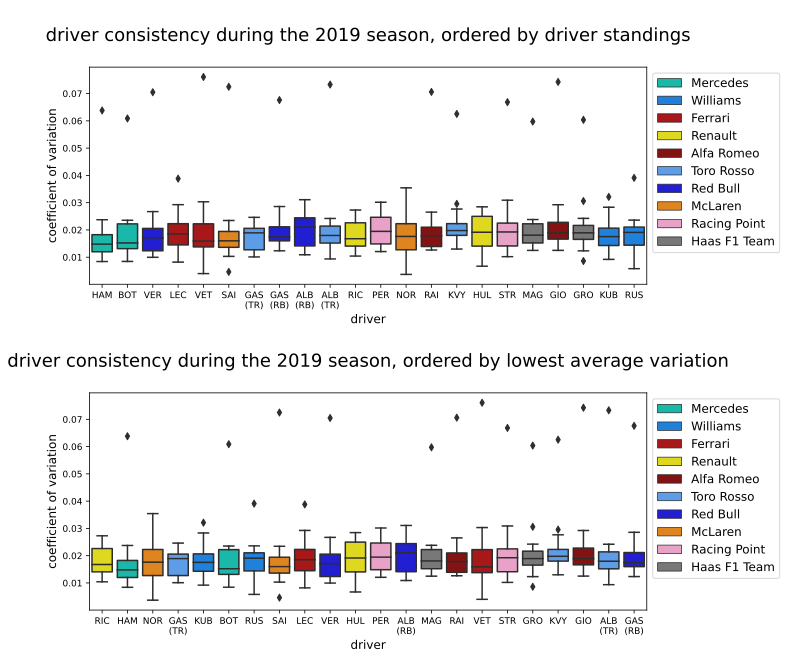

In [30]:
calc_variations(2019, plot=True);

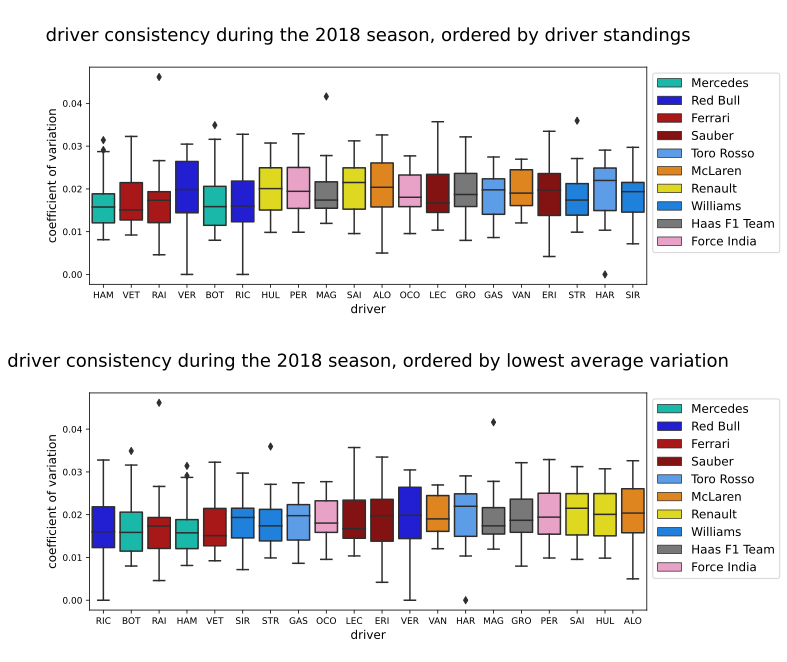

In [31]:
calc_variations(2018, plot=True);

<ipython-input-29-8119c35e4830>:93: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['driver'][(df['driver']==driver) &


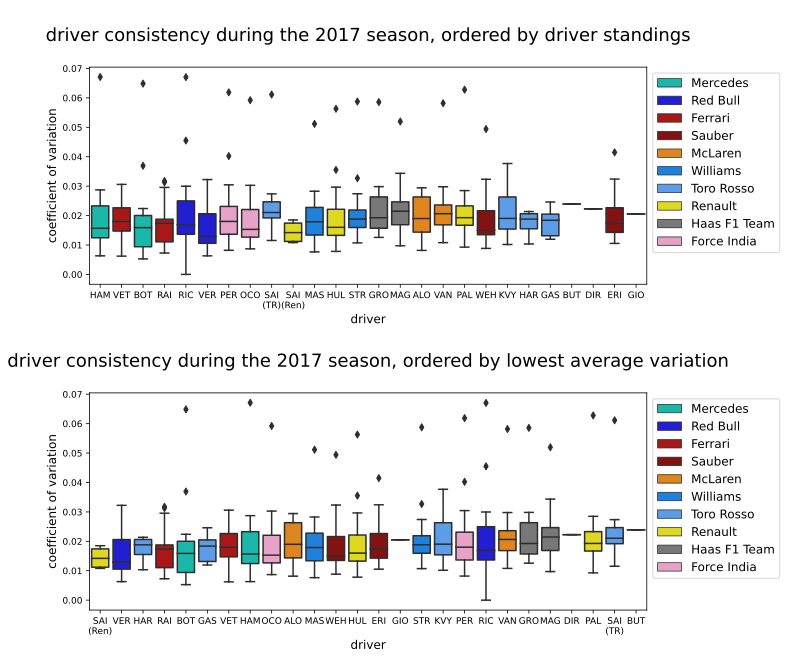

In [32]:
calc_variations(2017, plot=True);

<ipython-input-29-8119c35e4830>:93: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['driver'][(df['driver']==driver) &


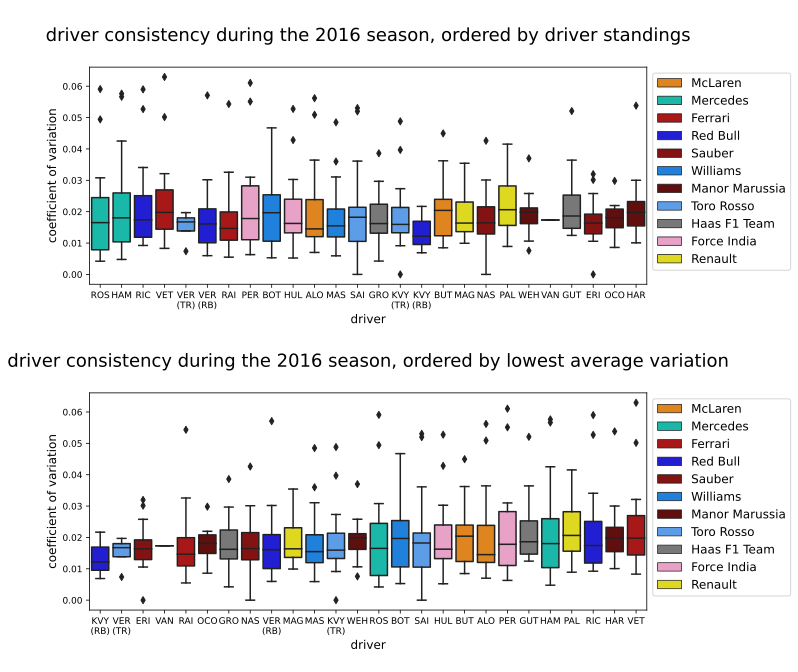

In [33]:
calc_variations(2016, plot=True);

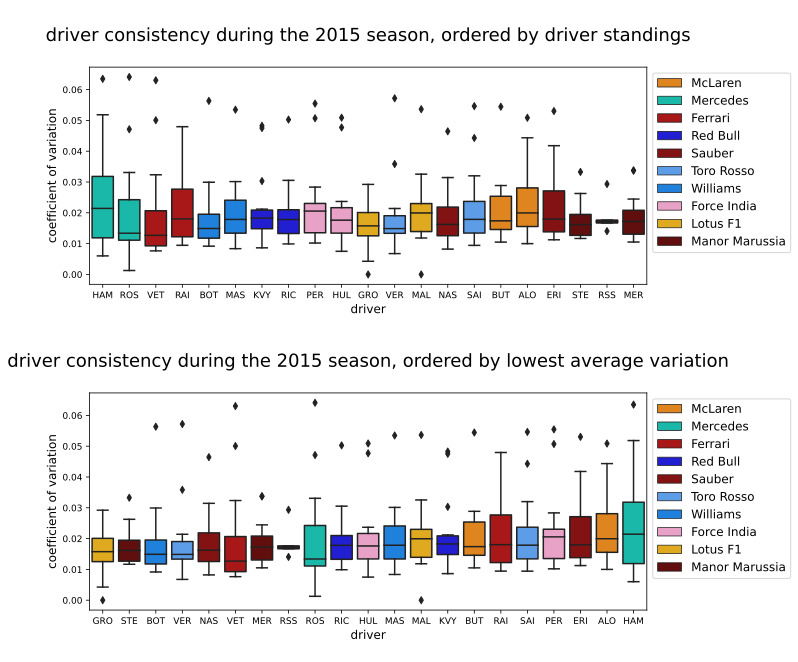

In [34]:
calc_variations(2015, plot=True);